___

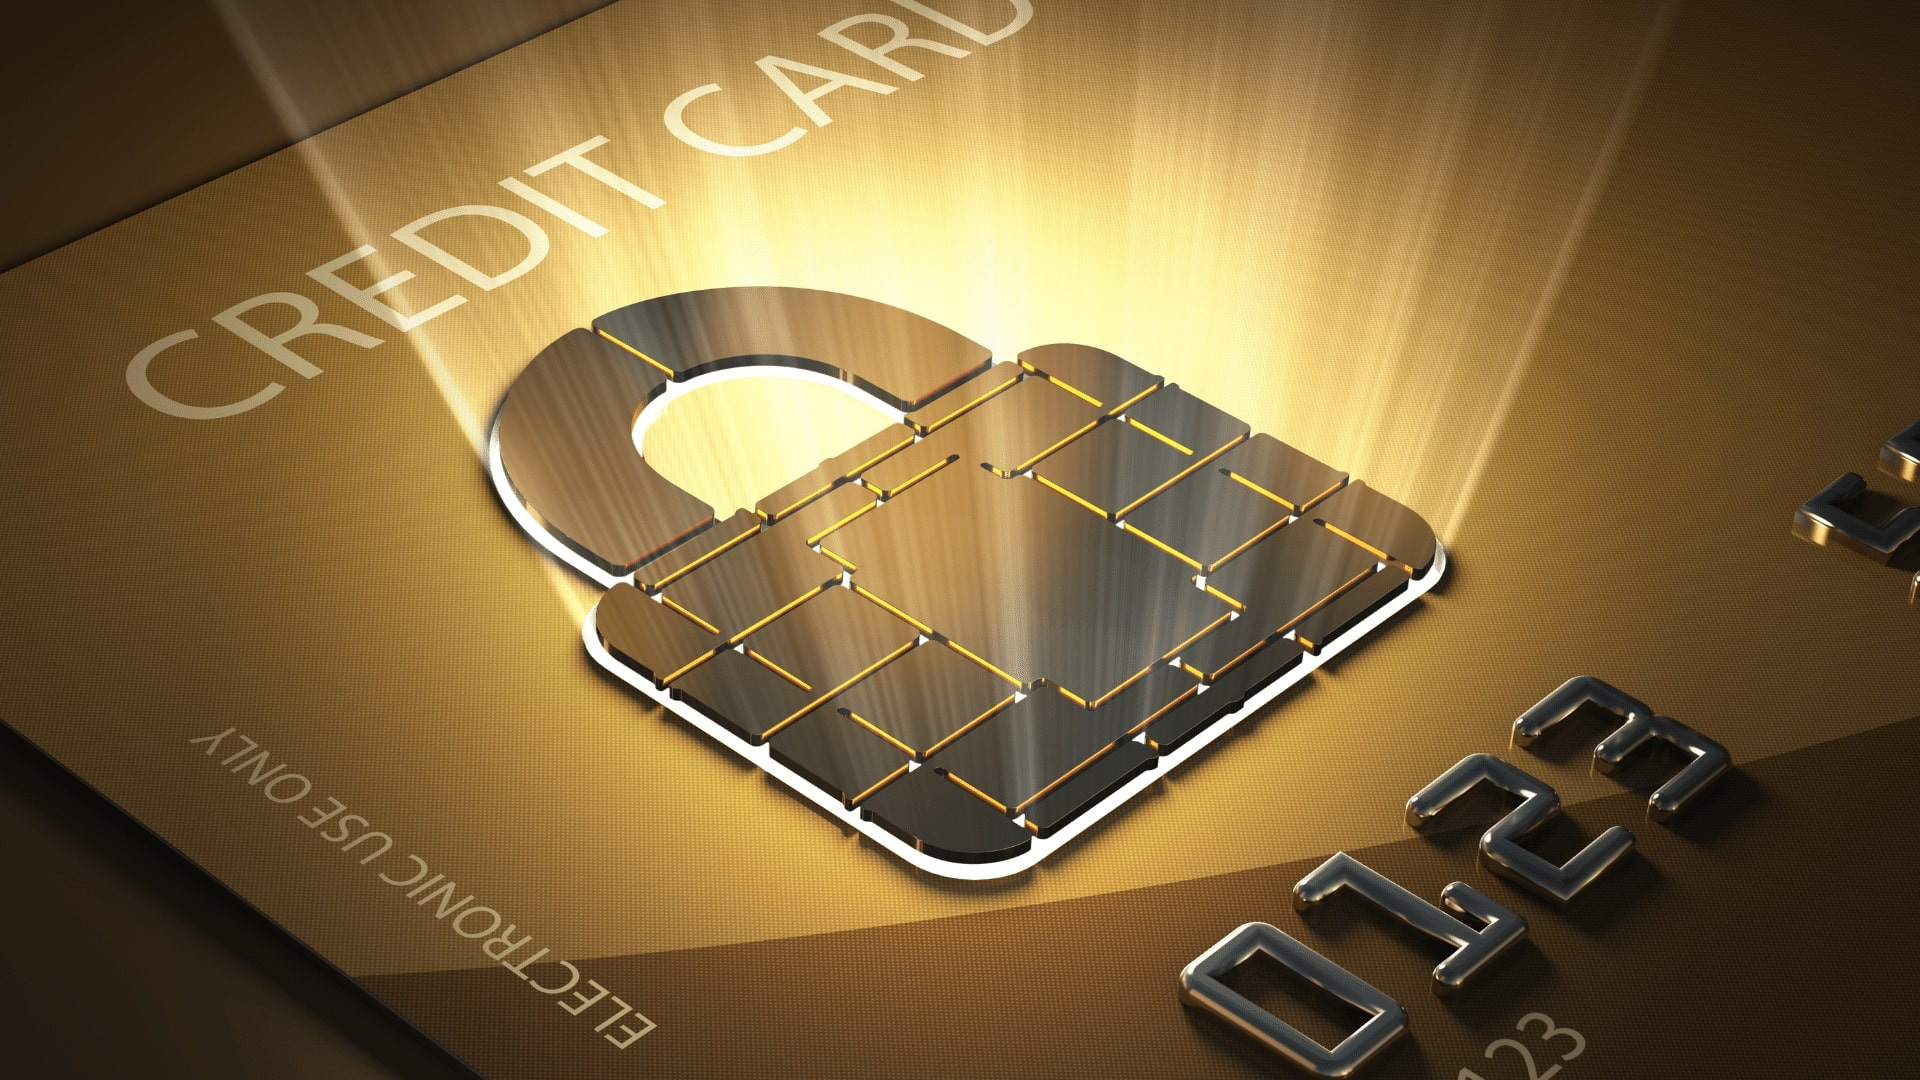
___

# Avaliação de Risco de Crédito com Machine Learning


Uma das área que causa mais problemas para bancos, financiadoras e empresários é a taxa de inadimplência por parte da sua carteira de clientes.

Avaliar se uma pessoa irá deixar de cumprir com suas obrigações financeiras é de extrema importância, e pode causar um grande impacto no balanço da Instituição. Cada vez mais, soluções vêm sendo desenvolvidas e aprimoradas visando minimizar o risco de *default*. 

*Default* é o termo utilizado para indicar o não cumprimento das obrigações e/ou condições de um empréstimo (como financiamentos ou dívidas de cartão de crédito). Normalmente, o principal motivo para o descumprimento das condições de pagamento é a incapacidade financeira do cliente.

Grandes bancos e Fintechs têm apostado cada vez mais em modelos de *Machine Learning* para prevenir a inadimplência de alguns clientes.

Dentre as principais instituições financeira, o [Nubank](https://nubank.com.br/sobre-nos) é uma das que mais tem se destacado no uso de Inteligência Artificial e times de *Data Science*.

O conjunto de dados a ser utilizado neste Projeto de *Data Science* parte de uma competição realizada pela Startup Nubank a fim de revelar talentos e potenciais contratações pela Fintech.

## Contextualização do Problema

Neste problema, o objetivo é prever qual a probabilidade de um cliente da Startup Nubank não cumprir com suas obrigações financeiras e deixar de pagar a sua fatura do Cartão de Crédito.

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/10/Nubank_logo.png" width="90px"></p>
  
Vale ressaltar que essa avaliação deve ser realizada no momento em que o cliente solicita o cartão (normalmente no primeiro contato com a instituição).



> OBJETIVO: Criar um modelo que forneça a probabilidade de um cliente virar inadimplente.


Espera-se que um modelo seja capaz de minimizar as perdas financeiras do Nubank, porém minimizando também os falsos positivos.

## Importar os Dados

Os dados que serão utilizados nesta análise estão disponíveis para download por meio [deste link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0).

Este arquivo será importando para uma estrutura *DataFrame* utilizando a biblioteca `pandas` a fim de possibilitar sua manipulação e análise.

In [ ]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importando os dados
df = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

## Análise Exploratória dos Dados

Esta etapa consiste em entender como os dados estão estruturados, os tipos de dados que compõe o dataset e etc.

O primeiro passo é entendermos a dimensão dos dados no dataset.

In [ ]:
#Imprimindos a dimensão das linhas e variáveis da base de dados
print("Quantidade de dados: ", df.shape[0])
print("Quantidade de variáveis: ", df.shape[1])

Quantidade de dados:  45000
Quantidade de variáveis:  43


O próximo passo é avaliarmos as 5 primeiras e últimas linhas do dataframe

In [ ]:
#Imprimindo as 5 primeiras linhas
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


In [ ]:
#Imprimindo as 5 últimas linhas
df.tail()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
44995,696cb747-1159-0a29-6731-8c52c6c42f5d,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,280.0,96.379531,0.416693,103.667082,0.17,14766.42,36.0,10627.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100013.24,False,x6Gw/1I8t3KPgT6s82Kodg==,Hfh28TzqkRno6rOU/tjy6Q==,NCqL3QBx0pscDnx3ixKwXg==,NaN,N5/CE7lSkAfB04hVFFwllw==,37.0,0.0,0.0,7.0,7.0,13:27:39,72,hotmail.com,0.0,2,1.0,7.0,ornilza,730,"(-22.486891256430695, -44.909010639017616)",Facebook,768-5074915,73417.0,BR-GO,52148,"{'tags': ['n1', 'n7', 'n4', 'n0']}",Mozilla/5.0 (Linux; Android 6.0.1; SM-G920V Bu...,NaN
44996,92cd9b1a-9a8e-43ad-5d96-8e999128b472,False,smzX0nxh5QlePvtVf6EAeg==,vJyc9xom9v7hwFMPTIpmKw==,370.0,96.124977,0.692196,97.977973,0.27,NaN,NaN,36262.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,95026.69,False,bwNrC22VlFOFk6/nEHQc6A==,vYKZVZfAwOMRjE0QGAYvbA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,16.0,16.0,22:50:49,51,gmail.com,NaN,1,NaN,1.0,deisilu,28,"(-12.881449687799003, -46.43545330884514)",Waiting-list,772-3517810,26246.0,BR-RO,46084,"{'tags': ['n11', 'n5', 'n12']}",Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,NaN
44997,febdd174-cf18-0be1-feb8-38399dd67d9e,False,e4NYDor1NOw6XKGE60AWFw==,ky19q4V1ZqgL3jnHX0wKDw==,280.0,102.377780,0.530938,93.687747,0.30,NaN,NaN,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,106020.90,NaN,xsd3ZdsI3356I3xMxZeiqQ==,Kihc6OKBTIHsGwCQy2Vruw==,NCqL3QBx0pscDnx3ixKwXg==,NaN,nSpvDsIsslUaX6GE6m6eQA==,7.0,0.0,0.0,6.0,6.0,09:60:49,476,gmail.com,NaN,2,1.0,27.0,elayne,940,"(-23.888982131800983, -50.645313285616645)",Waiting-list,334-9885724,101252.0,BR-SP,30570,"{'tags': ['dfa', 'c55', 'pro+aty']}",Mozilla/5.0 (Linux; Android 5.0.2; LG-V410/V41...,NaN
44998,a0a5a872-6165-b939-b711-37d045a0b5a8,True,smzX0nxh5QlePvtVf6EAeg==,6J1ZMTzN5GKHXnhM4J1JbA==,240.0,100.476090,0.214697,86.759074,0.37,NaN,NaN,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,185018.07,True,xsd3ZdsI3356I3xMxZeiqQ==,Kihc6OKBTIHsGwCQy2Vruw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,53.0,0.0,0.0,10.0,10.0,02:18:51,35,gmail.com,0.0,0,1.0,2.0,hidelburgo,459,"(-5.14769885524928, -37.98386842511541)",Instagram,238-9568414,129844.0,BR-SP,12742,"{'tags': ['n9', 'n2']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
44999,a7504e93-123a-f965-70c6-ab01a0d475f7,False,8k8UDR4Yx0qasAjkGrUZLw==,wkeCdGeu5sEv4/fjwR0aDg==,530.0,101.095813,0.011369,97.362918,0.31,4226.74,36.0,17942.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,34013.65,NaN,BB/zpwTH+8GCIVHlhzOU1Q==,8fTg1YyyuslJ5OATAWj5Ww==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,10.0,15:01:57,414,hotmail.com,0.0,1,NaN,45.0,genny,781,"(-23.13900985246712, -52.29465769715389)",Facebook,296-8101743,112766.0,BR-MT,41693,"{'tags': ['dfa', 'c55', 'pro+aty', 'n8', 'n4']}",Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like M...,NaN


Vamos criar uma função para entendermos de forma específica cada variável que compõe o dataset.

In [ ]:
def Map_Var_DF (features, df):
  #Criando um dicionário para receber as variáveis
  dict_var = {"feature": [],
              "Tipo": [],
              "Categórico": [],
              "Binário": [],
              "Qtd var unico": [],
              "Min": [],
              "Max": [],
              "% Qtd de Nulos": []}

  #Criando um loop a partir das features
  for feature in features:

    #Armazenando o nome da feature
    dict_var['feature'].append(feature)

    #Armazenando o tipo da variável
    dict_var['Tipo'].append(df[feature].dtypes)

    #Armazenando a quantidade de valores nulos
    dict_var['% Qtd de Nulos'].append(round(df[feature].isnull().sum() / df.shape[0],4))

    if ((df[feature].dtype == "O")):

      #Atribuindo o valor 1 se a variável for categórica
      dict_var['Categórico'].append(1)

      #Armazenando a quantidade de valores únicos
      dict_var['Qtd var unico'].append(df[feature].nunique())

      #Armazenando os valores mínimos
      dict_var['Min'].append("N/A")

      #Armazenando os valores máximos
      dict_var['Max'].append("N/A")

      if (df[feature].nunique() == 2):

        #Atribuindo o valor 1 se a variável for binária
        dict_var['Binário'].append(1)
        
      else:

        #Atribuindo o valor 0 se a variável não for binária
        dict_var['Binário'].append(0)

    else:

      #Atribuindo o valor 0 se a variável não for categórica
      dict_var['Categórico'].append(0)

      #Armazenando a quantidade de valores únicos
      dict_var['Qtd var unico'].append(df[feature].nunique())

      #Atribuindo o valor 0 se a variável não for binária
      dict_var['Binário'].append(0)

      #Armazenando os valores mínimos
      dict_var['Min'].append(df[feature].min())

      #Armazenando os valores máximos
      dict_var['Max'].append(df[feature].max())
      
  #Transformando o dicionário em dataframe
  df_var = pd.DataFrame.from_dict(data = dict_var)

  #Imprimindo o dataframe
  return df_var

Vamos criar um dataframe com as características das features

In [ ]:
#Armazenando as features
features = df.columns.to_list()

#Armazenando as informações das variáveis
df_var = Map_Var_DF(features = features, df = df)

#Imprimindo o dataframe
df_var

,feature,Tipo,Categórico,Binário,Qtd var unico,Min,Max,% Qtd de Nulos
0,ids,object,1,0,45000,N/A,N/A,0.0000
1,target_default,object,1,1,2,N/A,N/A,0.0724
2,score_1,object,1,0,7,N/A,N/A,0.0125
3,score_2,object,1,0,35,N/A,N/A,0.0125
4,score_3,float64,0,0,88,0,990,0.0125
5,score_4,float64,0,0,45000,86.1916,113.978,0.0000
6,score_5,float64,0,0,45000,3.54358e-05,0.999973,0.0000
7,score_6,float64,0,0,45000,60.663,142.192,0.0000
8,risk_rate,float64,0,0,82,0,0.9,0.0125
9,last_amount_borrowed,float64,0,0,14325,1005.18,35059.6,0.6657


A partir do dataframe das features é possível concluir que:
* A coluna **target_default** é a variável alvo do problema. Vale destacar que possui alguns valores ausentes que deverão ser excluídos do dataset;
* A coluna **target_fraud** é uma variável alvo destinada para avaliar a possibilidade de fraude no cartão de crédito. Como não é objeto deste estudo, esta coluna será excluída do dataset; 
* As variáveis **last_amount_borrowed**, **last_borrowed_in_months**, **ok_since** e **external_data_provider_credit_checks_last_2_year** possuem mais de 50% do dataset de valores ausentes, sendo difícil substituir tais valores, podendo gerar erros durante a predição. Portanto, estas colunas serão excluídas;
* As variáveis **job_name**, **external_data_provider_first_name**, **profile_phone_number** e **zip** são do tipo string e possuem muitos valores categóricos distintos, difíceis de serem agrupados, portanto estas colunas serão excluídas;
* A variável **external_data_provider_email_seen_before** possui um valor mínimo em -999, provavelmente este campo recebeu este valor, porque o sistema de cadastro não permitia valores nulos para preenchimento. Portanto, estes valores serão considerados como NaN;
* A variável **reported_income** possui um valor máximo de infinito, portanto, este valor será substituído por NaN;
* A variável **credit_limit** possui um mínimo de 0 reais, não é uma prática do mercado de cartão de crédito liberar apenas 0 reais de limite. Portanto, este valor será substituído por NaN;
* Criaremos uma variável de agrupamento por região do Brasil, utilizando a variável **shipping_state**;
* A variável **ids** serve para identificar um determinado cliente, portanto, não agrega valor no objetivo proposto e esta coluna será excluída;
* A variável **channel** apenas tem um valor único, portanto, não agrega valor a análise e será excluída;
* As variáveis **lat_lon** e **shipping_zip_code** serão excluídas do dataset para simplificar a modelagem.

O próximo passo é excluir os valores ausentes da variável alvo **target_default** e as colunas mencionadas na análise anterior. Além disso, vamos substituir por NaN, os valores negativos, infinitos e 0 das variáveis **external_data_provider_email_seen_before**, **reported_income** e **credit_limit**, respectivamente.

In [ ]:
#Copiando o dataset
df_clean = df.copy()

#Exluindo os valores ausentes da variável alvo
df_clean.dropna(subset = ['target_default'] ,inplace = True)

#Armazenando as variáveis a serem excluídas
Col_Ex = ['target_fraud',
          'last_amount_borrowed',
          'last_borrowed_in_months',
          'ok_since',
          'external_data_provider_credit_checks_last_2_year',
          'job_name',
          'external_data_provider_first_name',
          'profile_phone_number',
          'ids',
          'channel',
          'zip',
          'lat_lon',
          'shipping_zip_code']

#Exluindo as colunas do dataframe
df_clean.drop(labels = Col_Ex, axis = 1, inplace = True)

#Substintuindo os valores negativos por NaN
df_clean['external_data_provider_email_seen_before'] = df_clean['external_data_provider_email_seen_before'].apply(lambda x: np.nan if x < 0 else x)
df_clean['reported_income'] = df_clean['reported_income'].apply(lambda x: np.nan if x == np.inf else x)
df_clean['credit_limit'] = df_clean['credit_limit'].apply(lambda x: np.nan if x == 0 else x)

Vamos verificar os valores únicos da variável **email** para definir se será necessário realizar alguma correção.

In [ ]:
#Imprimindo os valores únicos da variável email
df_clean['email'].unique()

array(['outlook.com', 'gmail.com', 'spgov.com', 'hotmail.com',
       'hotmaill.com', 'gmaill.com'], dtype=object)

Podemos verificar que será necessário corrigir os nomes "gmaill.com" e "hotmaill.com" para "gmail.com" e "hotmail.com", respectivamente.

In [ ]:
#Corrigindo as descrições do hotmail e gmail
df_clean['email'] = df_clean['email'].apply(lambda x: 'hotmail.com' if x == 'hotmaill.com' else x)
df_clean['email'] = df_clean['email'].apply(lambda x: 'gmail.com' if x == 'gmaill.com' else x)

Após os tratamentos, vamos replicar a função para extrair as informações do dataframe e podermos retirar mais insigths a respeito das features.

In [ ]:
#Armazenando as features do dataframe
features_clean = df_clean.columns.to_list()

#Replicando a função
var_df_clean = Map_Var_DF(features = features_clean, df = df_clean)

#Imprimindo o datafram
var_df_clean

,feature,Tipo,Categórico,Binário,Qtd var unico,Min,Max,% Qtd de Nulos
0,target_default,object,1,1,2,N/A,N/A,0.0000
1,score_1,object,1,0,7,N/A,N/A,0.0000
2,score_2,object,1,0,35,N/A,N/A,0.0000
3,score_3,float64,0,0,87,0,990,0.0000
4,score_4,float64,0,0,41741,86.1916,113.978,0.0000
5,score_5,float64,0,0,41741,3.54358e-05,0.999973,0.0000
6,score_6,float64,0,0,41741,60.663,142.192,0.0000
7,risk_rate,float64,0,0,81,0,0.9,0.0000
8,credit_limit,float64,0,0,19335,300,448269,0.4315
9,reason,object,1,0,14260,N/A,N/A,0.0001


Podemos concluir que algumas variáveis deixaram de ter valores ausentes quando excluímos os valores ausentes da variável alvo. 

### Tratamento - Valores Ausentes
O próximo passo é tratarmos os valores ausentes e utilizaremos as seguintes regras:
* Utilizar os valores mais frequentes para as variáveis categóricas;
* Utilizar a mediana para os valores numéricos;
* A variável credit_limit será excluída do dataset, devido ao número alto de dados de ausentes após o tratamento;



In [ ]:
#Excluindo a variável credit_limit
df_clean.drop(labels = ['credit_limit'], axis = 1, inplace = True)

#Armazenando as variáveis a serem tratadas
cat_df = var_df_clean['feature'].loc[ (var_df_clean['Categórico'] == 1)].to_list()
num_df = var_df_clean['feature'].loc[ (var_df_clean['Categórico'] == 0) & (var_df_clean['feature'] != 'credit_limit') ].to_list()

# variáveis numéricas
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_clean[num_df])
df_clean[num_df] = imputer.transform(df_clean[num_df])

# variáveis categóricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_clean[cat_df])
df_clean[cat_df] = imputer.transform(df_clean[cat_df])

Vamos avaliar novamente a tabela de features após este tratamento

In [ ]:
#Armazenando as features do dataframe
features_clean = df_clean.columns.to_list()

#Replicando a função
var_df_clean = Map_Var_DF(features = features_clean, df = df_clean)

#Imprimindo o datafram
var_df_clean

,feature,Tipo,Categórico,Binário,Qtd var unico,Min,Max,% Qtd de Nulos
0,target_default,bool,0,0,2,False,True,0.0
1,score_1,object,1,0,7,N/A,N/A,0.0
2,score_2,object,1,0,35,N/A,N/A,0.0
3,score_3,float64,0,0,87,0,990,0.0
4,score_4,float64,0,0,41741,86.1916,113.978,0.0
5,score_5,float64,0,0,41741,3.54358e-05,0.999973,0.0
6,score_6,float64,0,0,41741,60.663,142.192,0.0
7,risk_rate,float64,0,0,81,0,0.9,0.0
8,reason,object,1,0,14260,N/A,N/A,0.0
9,income,float64,0,0,38849,4821.18,5.00003e+06,0.0


Como podemos observar, não existe mais valores nulos em nosso banco de dados.


### Tratamento de outliers

O próximo passo é plotar um gráfico de boxplot para avaliar a presença de outliers. 

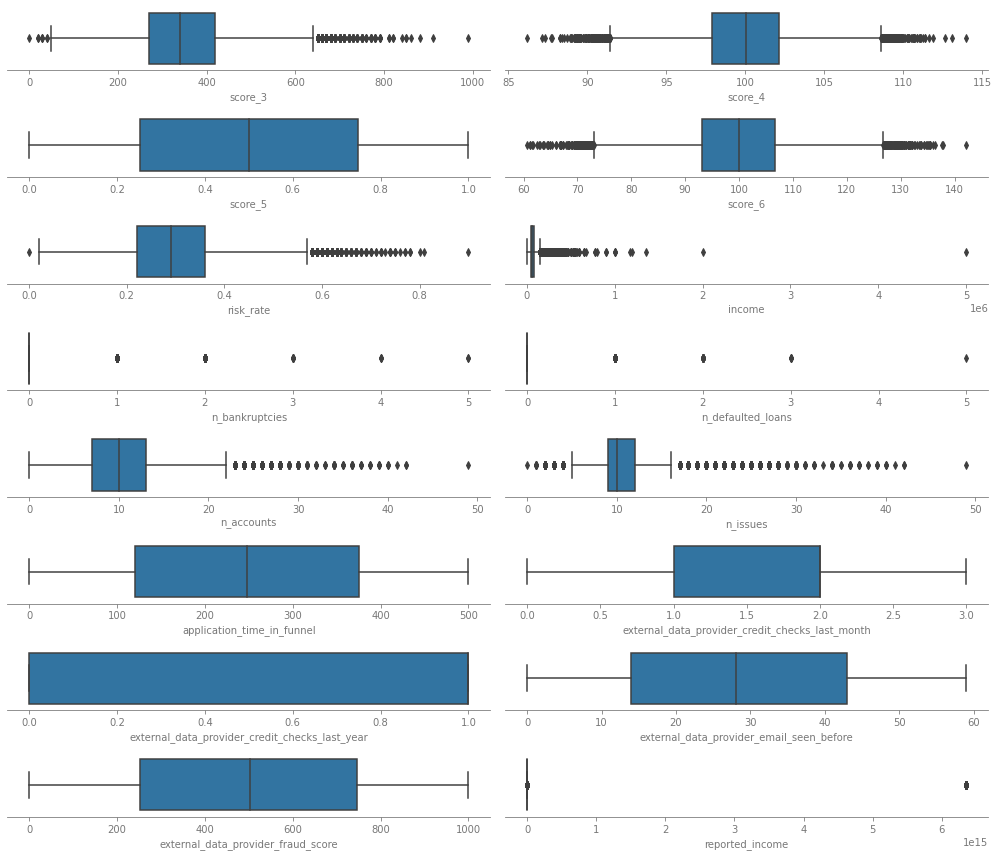

In [ ]:
#Armazenando as features numéricas
num_feature = var_df_clean['feature'].loc[ (var_df_clean['Tipo'] == 'float64') ].to_list()

#Contador
cont_x = 0
cont_y = 0

#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False,
             'axes.spines.left': False, 
             'ytick.left': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

#Aplicando os parâmetros no matplotlib/seaborn
with plt.rc_context(rc_params):

  #Instanciando a figure e axes
  fig, ax = plt.subplots(nrows = 8, ncols = 2, figsize = (14,12) )

  #Rodando loop entre as features numéricas
  for feature in num_feature:

    #Criando o Box Plot para as features
    sns.boxplot(x = feature, data = df_clean, ax = ax[cont_x,cont_y])

    #Atualizando os valores dos contadores para o axes
    if cont_y == 1:
      cont_x = cont_x + 1
      cont_y = 0

    else :
      cont_y = cont_y + 1

  #Imprimindo os gráficos
  fig.tight_layout()

A partir do Boxplot é possível notar a presença de outliers em algumas features. Porém, não iremos aplicar o método de IQR score para retirar estas anomalias em variáveis como **score**, **risk_rate** e entre outras que podem enfraquecer nosso modelo de machine learning em casos reais.
Portanto, iremos aplicar o método apenas nas variáveis: **income**, **reported_income**, **n_accounts** e **n_issue**.

In [ ]:
#armazenando as features para utilizar o método IQR Score
feature_IQR = ['income',
               'reported_income',
               'n_accounts',
               'n_issues']

#Loop em relação as features
for feature in feature_IQR:

  Q1 = df_clean[feature].quantile(q = 0.25) #Definindo o primeiro quartil
  Q3 = df_clean[feature].quantile(q = 0.75) #Definindo o segundo quartil
  IQR = Q3 - Q1 #Definindo o interquartil
  Limite_Superior = Q3 + IQR #Definindo o Limite Superior
  Limite_Inferior = Q1 - IQR #Definindo o Limite Inferior

  #Eliminando os outliers acima do limite superior
  df_clean.drop( df_clean.loc[ df_clean[feature] > Limite_Superior ].index, axis = 0, inplace = True )

  #Eliminando os outliers abaixo do limite inferior
  df_clean.drop( df_clean.loc[ df_clean[feature] < Limite_Inferior ].index, axis = 0, inplace = True )

### Feature Engineering
Nesta etapa, vamos buscar alternativas para criar variáveis para aumentar o repertório durante a modelagem em busca de uma maior robustez.


#### Variável **application_time_applied**

Esta variável está no formato de "hh:mm:ss" e vamos utilizar apenas a parcela associadas a horas para facilitar a modelagem.
Vale destacar que esta variável está classificada como string ao invés de datetime, portanto, será convertida para inteiro após o tratamento mencionado.

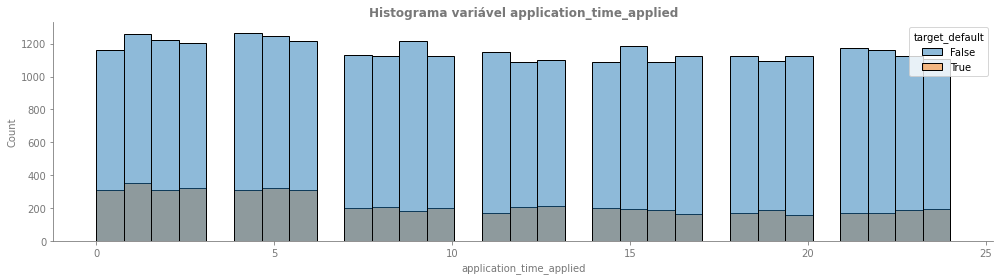

In [ ]:
#Considerando apenas a hora e convertendo para inteiro
df_clean['application_time_applied'] = df_clean['application_time_applied'].str[:2].astype('int64')

#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

#Aplicando os parâmetros no matplotlib/seaborn
with plt.rc_context(rc_params):

  #Instanciando o objeto figure e axes
  fig, ax = plt.subplots( figsize = (14,4) )

  #Criando um histograma para a variável tenure
  sns.histplot(data = df_clean, x = 'application_time_applied', ax = ax, hue = "target_default")

  #Setando o título do gráfico
  ax.set_title("Histograma variável application_time_applied")

  #Exibindo o gráfico
  plt.tight_layout()

Como podemos observar as aplicações realizadas no período de 0 a 6 h possuem maior probabilidade de terem inadimplência.

#### Variável **profile_tags**

A Nubank atribui algumas Tags para os clientes e os armazena como um dicionário na variável **profile_tags**. Apesar de não sabermos os significado das Tags, podem ter um nível de significância para a predição do modelo de machine learning. Portanto, faremos um tratamento para extrair tais informações e criar colunas associadas a cada Tag.

Antes de iniciarmos este processo, temos que extrair as Tags do dicionário.

In [ ]:
#Retirando o padrão dicionário
df_clean['profile_tags'] = df_clean['profile_tags'].str.extract('\[(.*)\]')

#Retirando as aspas e vírgulas
df_clean['profile_tags'] = df_clean['profile_tags'].str.replace("'","").str.replace(",","").str.replace("+","")

#Imprimindo as 5 primeiras linhas
df_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,reason,income,facebook_profile,state,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,reported_income,shipping_state,profile_tags,user_agent
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,2,346.0,gmail.com,1.0,0.0,17.0,243.0,Radio-commercial,4902.0,BR-RS,n6 n7 nim,Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...
2,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,False,Ygq6MsM98oC8yceExr69Ig==,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,10.0,0,6.0,gmail.com,2.0,1.0,9.0,65.0,Waiting-list,163679.0,BR-RR,n0 n17 nim da,Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
4,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,10.0,13,240.0,gmail.com,2.0,1.0,46.0,320.0,Invite-email,198618.0,BR-MT,proaty n19 da b19,Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...
5,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,300.0,101.837040,0.915389,90.711273,0.44,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,75024.28,False,JrdZzPZEa/YIIGwh8OdTKA==,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,9.0,9.0,5,169.0,gmail.com,2.0,1.0,21.0,811.0,Website,160198.0,BR-SP,c1 n3 n9,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 6P Bu...
6,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,250.0,98.958914,0.901736,108.609675,0.43,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,49234.65,False,xsd3ZdsI3356I3xMxZeiqQ==,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,8.0,10.0,8,74.0,gmail.com,2.0,0.0,16.0,527.0,Twitter,132928.0,BR-SP,n3,Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like M...


O próximo passo é colocar as Tags em colunas, utilizando o algoritmo CountVectorizer do Scikit-learn. Este algoritmo serve para contar a quantidade de vezes que uma palavra aparece em um texto. Porém, para atender ao objetivo proposto, utilizaremos o argumento chamado binary que retorna 1 para caso a palavra esteja no texto e 0 para o contrário.

In [ ]:
#Setando o algoritmo
bag_of_words = CountVectorizer(binary=True, analyzer='word')

#Treinando o algoritmo
words = bag_of_words.fit_transform(df_clean['profile_tags']).todense()

#Criando um dataframe a partir da matriz criada
df_tag = pd.DataFrame(words, columns = bag_of_words.get_feature_names(), index = df_clean.index)

#Imprmindo o dataframe
df_tag.head()

,a15,aty,b19,c1,c55,da,dfa,n0,n1,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,n2,n3,n4,n5,n6,n7,n8,n9,nim,proaty
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


O próximo passo é excluirmos a variável **profile_tags** e juntar o dataframe com o da base de dados de inadimplência

In [ ]:
#unindo os dataframes
df_clean_novo = pd.concat([df_clean, df_tag], axis = 1)

#Excluindo a variável profile_tags
df_clean_novo.drop(labels = ['profile_tags'], axis = 1, inplace = True)

#### Variável **Reason**

Vamos avaliar se conseguimos agrupar os valores da reason por frequência de ocorrência. 

In [ ]:
#Avaliando o % de frequência dos atributos da reason
df_clean_novo['reason'].value_counts()/df_clean_novo.shape[0]

mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIXuusuYraWV4rGB3v/7WqHKeKq5W600DOWmwjMTqsrAW    0.094208
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIXuusuYraWV4rGB3v/7WqHIRsMoD5e3RXcnWOgQJkT1p    0.066555
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIW76/BS2rZFHqQxXY+8F9NKu9aZ57vT61+K2XFrHtvT9    0.032756
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiH9ooDQPWyPZgJWyjKkQUjr    0.021653
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIRd8GOItgxlRAUGKcWd5xXCeKq5W600DOWmwjMTqsrAW    0.020117
                                                                                                                                      ...   
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIX9dbhZpFZlnjBHYIj17Xi9FUc/gp1pJyKjQyhTKsaf+    0.000029
mLVIVxoGY7TUD

Vamos criar uma variável em que atribuiremos o valor 1 para as os atributos acima de 2% de frequência e o valor 0 para caso a condição não seja atendida.

In [ ]:
#Armazenando os % em um dicionário
dict_reason = (df_clean_novo['reason'].value_counts()/df_clean_novo.shape[0]).to_dict()

#Criando uma nova variável
df_clean_novo['mais_freq'] = df_clean_novo['reason'].apply(lambda x: 1 if dict_reason[x] > 0.02 else 0)

Após a criação, o próximo passo é excluirmos a variável **reason** do dataset.

In [ ]:
#Excluindo a variável reason do dataset
df_clean_novo.drop(labels = ['reason'], axis = 1, inplace = True)

#### Variável **user_agent**


Esta variável armazena os dados do sistema operacional do usuário que está sendo utilizado para fazer aplicação. Portanto, vamos criar uma função para extrair o sistema operacional do usuário em meio a um conjunto de caracteres.

In [ ]:
def DefinirSO(string):

  #Lista de sistema para buscar
  Lista_SO = ['android',
              'iphone',
              'ubuntu',
              'windows',
              'macintosh']

  #Variável para armazenar o resultado
  result = ""

  #passando a string para minúsculo
  string_lower = string.lower()

  #Roda um loop em relação a lista
  for so in Lista_SO:

    #Verifica se o sistema está contido no conjunto de caracteres
    if so in string_lower:

      #Armazena o sistema
      result = so
  
  #Retorna o resultado da busca
  if result == "":
    return "Outro"
  else:
    return result

Vamos criar uma variável para armazenar o sistema operacional.

In [ ]:
#Criando a variável
df_clean_novo['SO'] = df_clean_novo['user_agent'].apply(DefinirSO)

O próximo passo é excluirmos a variável **user_agent**.

In [ ]:
#Excluindo a variável
df_clean_novo.drop( labels = ['user_agent'], axis = 1, inplace = True )

#### Variável **shipping_state**

Vamos agrupar esta variável por região para reduzir a complexidade do modelo, eliminando a necessidade de criar uma variável por estado brasileiro.

In [ ]:
#Dicionário de estado por região
dict_regiao = {'BR-RS' : 'Sul', 
               'BR-RR': 'Norte', 
               'BR-MT': 'Centro-Oeste', 
               'BR-SP': 'Sudeste', 
               'BR-AC': 'Norte', 
               'BR-MS': 'Centro-Oeste', 
               'BR-PE': 'Nordeste',
               'BR-AM': 'Norte', 
               'BR-CE': 'Nordeste', 
               'BR-AP': 'Norte', 
               'BR-MA': 'Nosdeste', 
               'BR-BA': 'Nordeste', 
               'BR-TO': 'Norte', 
               'BR-RO': 'Norte',
               'BR-GO': 'Centro-Oeste', 
               'BR-SE': 'Nordeste', 
               'BR-RN': 'Nordeste', 
               'BR-MG': 'Sudeste', 
               'BR-ES': 'Sudeste', 
               'BR-PR': 'Sul', 
               'BR-DF': 'Centro-Oeste',
               'BR-SC': 'Sul', 
               'BR-PA': 'Norte', 
               'BR-AL': 'Nordeste', 
               'BR-PB': 'Nordeste'}

In [ ]:
#Criando uma variável por região
df_clean_novo['regiao'] = df_clean_novo['shipping_state'].apply(lambda x: dict_regiao[x])

Vamos eliminar a variável **shipping_state** do dataset.

In [ ]:
#Eliminando a variável shipping_state
df_clean_novo.drop(labels = ['shipping_state'], axis = 1, inplace = True)

### Dados Balanceados?
Este passo tem a finalidade de avarliarmos se os dados estão balanceados em relação a variável alvo (target_default)

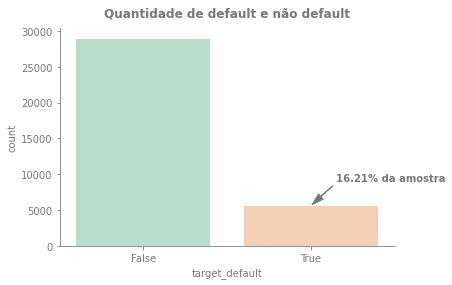

In [ ]:
#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12
             }

#setando os parâmetros no matplotlib
with plt.rc_context(rc_params):

  #Instanciando a Figure e Axes
  fig, ax = plt.subplots()

  #Criando o gráfico de countplot
  sns.countplot(x = 'target_default', 
                data = df_clean_novo,
                ax = ax,
                palette = "Pastel2")
  
  #Exibindo o título
  ax.set_title("Quantidade de default e não default")

  #Armazena o % da amostra
  percentual_default = round((df_clean_novo['target_default'].value_counts()[1] / df_clean_novo.shape[0])*100,2)

  #Criar uma informação no gráfico
  ax.annotate(str(percentual_default) + "% da amostra", 
              xy = (1, df_clean_novo['target_default'].value_counts()[1]), 
              xytext = (25,25), 
              color = "#787878",
              weight = 'bold', 
              textcoords='offset points',
              arrowprops=dict(color = '#787878',  shrink= 0.05, width = 0.01, headwidth = 7))

  #Exibindo o gráfico
  plt.show()

Como mostrado no gráfico, os dados relacionados com a variável alvo **target_default** está desbalanceada, visto que apenas 16,21% dos dados totais estão relacionados com inadimplência.

Isto gera um problema durante a predição do modelo de machine learning, porque é mais cômodo para o algoritmo classificar a maioria dos casos como no default. Diante disto, será necessário balancear amostra. Este passo será mostrado e explicado durante a fase de preparação dos dados.

## Modelo de Machine Learning

Antes de iniciarmos qualquer processo para avaliar o melhor modelo de machine learning para o problema envolvendo inadimplência, temos que realizar uma preparação dos dados.

#### Preparação dos dados

Nesta fase iremos preparar os dados para permitir que possamos aplicar os variados modelos de machine learning. Portanto, o primeiro passo é transformar as variáveis categóricas em valores numéricos.

Para isso, utilizaremos **LabelEncoder** da biblioteca do Scikit-Learn para transformar as variáveis binárias em valores de 0 e 1. Enquanto, para as variáveis que são categóricas e não binárias, utilizaremos o método **get_dummies** do Pandas que funciona de forma similar ao OneHotEncoder do Scikit-Learn com algumas facilidades para agilizar o processo.

Antes de iniciar este processo, vamos armazenar o nome das variáveis categóricas, binárias e numéricas em uma lista. Esta etapa facilitará tanto o processo de codificação quanto posteriormente quando aplicaremos a técnica de scaling feature nas variáveis numéricas.

Vale destacar que este processo não será realizado para as variáveis oriundas das features **profile_tags** e **reason**, já que as mesmas se encontram tratadas e transformadas em numéricas.

In [ ]:
#Lista de variáveis numéricas
var_num = ['score_3', 
           'score_4', 
           'score_5', 
           'score_6', 
           'risk_rate', 
           'income', 
           'n_bankruptcies', 
           'n_defaulted_loans', 
           'n_accounts',
           'n_issues', 
           'application_time_applied', 
           'application_time_in_funnel', 
           'external_data_provider_credit_checks_last_month',
           'external_data_provider_credit_checks_last_year',
           'external_data_provider_email_seen_before',
           'external_data_provider_fraud_score', 
           'reported_income']

#Lista de variáveis binárias (LabelEncoder)
var_bin = ['target_default', 
           'facebook_profile']

#Lista de variáveis categóricas (getdummies)
var_cat = ['score_1', 
           'score_2', 
           'state', 
           'real_state', 
           'email', 
           'marketing_channel', 
           'SO', 
           'regiao']

In [ ]:
#Vamos copiar o dataframe
df_trat = df_clean_novo.copy()

#Instanciando o objeto labelEncoder
le = LabelEncoder()

#Criando um loop para codificar as variáveis binárias
for feature in var_bin:

  #transformando os valores binários em numéricos
  df_trat[feature] = le.fit_transform(df_trat[feature])

#Aplicando o get_dummies nas variáveis categóricas
df_trat = pd.get_dummies(data = df_trat, columns = var_cat)

Vamos avaliar as 5 primeiras linhas para verificar como ficaram as codificações.

In [ ]:
#Imprimindo as 5 primeiras linhas
df_trat.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,income,facebook_profile,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,a15,aty,b19,c1,c55,da,dfa,n0,n1,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,n2,n3,...,state_kfFcVGcsJmH2n3eYprLkeQ==,state_orU7WJYGPT/xFwOXY1eBkw==,state_qItmSqWrjm+MopDA+UpKRw==,state_rrVbgRNTRyB6auEycsRrpA==,state_sjJbkqJS7cXalHLBFA+EOQ==,state_umkEte5GXWggFkMOtKQ3Ug==,state_x6Gw/1I8t3KPgT6s82Kodg==,state_xsd3ZdsI3356I3xMxZeiqQ==,state_ygE7OTdsxRMLeXMa0EZwZw==,state_yni6lL4oSly97UVZeRSyxA==,real_state_+qWF9pJpVGtTFn4vFjb/cg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==,email_gmail.com,email_hotmail.com,email_outlook.com,email_spgov.com,marketing_channel_Facebook,marketing_channel_Instagram,marketing_channel_Invite-email,marketing_channel_Invite-web,marketing_channel_LinkedIn,marketing_channel_Radio-commercial,marketing_channel_Twitter,marketing_channel_Waiting-list,marketing_channel_Website,SO_Outro,SO_android,SO_iphone,SO_macintosh,SO_ubuntu,SO_windows,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Nosdeste,regiao_Sudeste,regiao_Sul
1,0,370.0,97.062615,0.942655,92.002546,0.24,100018.91,0,0.0,0.0,14.0,14.0,2,346.0,1.0,0.0,17.0,243.0,4902.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,360.0,100.027073,0.351918,112.892453,0.29,65023.65,0,0.0,0.0,10.0,10.0,0,6.0,2.0,1.0,9.0,65.0,163679.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,60011.29,1,0.0,0.0,11.0,10.0,13,240.0,2.0,1.0,46.0,320.0,198618.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
5,0,300.0,101.837040,0.915389,90.711273,0.44,75024.28,0,0.0,0.0,9.0,9.0,5,169.0,2.0,1.0,21.0,811.0,160198.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
6,0,250.0,98.958914,0.901736,108.609675,0.43,49234.65,0,0.0,0.0,8.0,10.0,8,74.0,2.0,0.0,16.0,527.0,132928.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


O próximo passo é dividirmos a base de dados entre treino e teste. Este passo é importante para ajustarmos os modelos de machine learning com base no dataset de treino, escolher o melhor modelo com base na sua performance e fazer todas as otimizações necessárias para que no final possamos validar o nível de generalização do modelo com base em dados desconhecidos (teste).

Além disso, para podermos dividir os dados em treino e teste, precisamos definir os valores de X (variáveis independentes) e y (target_default - variável alvo).


In [ ]:
#Definindo os valores de X e y
X = df_trat.drop(['target_default'], axis = 1)
y = df_trat['target_default']

#Dividindo o dataset em treino e test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle = True, 
                                                    stratify = y,
                                                    random_state = 42)

O próximo passo é balancear os dados para evitar que a predição fique enviesada e limite a capacidade do modelo em generalizar.

Esta etapa pode ser feita por duas maneiras, conforme indicado por [Carlos Melo](https://sigmoidal.ai/como-lidar-com-dados-desbalanceados/):

>* Over-sampling: cria novas observações da classe minoritária a partir das informações contidas nos dados originais. Essa geração de novas entradas pode ser feita aleatoriamente com o auxílio de técnicas de clustering ou sinteticamente.
* Under-sampling: reduz o desbalanceamento do dataset focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.

Utilizaremos como base a técnica de **under-sampling**, devido a possibilidade de mantermos integralmente os dados originais associados a **target_default**.

In [ ]:
#Instanciando o objeto RandomUnderSampler()
rus = RandomUnderSampler(random_state = 0)

#Balanceando a amostra
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

#Transformando o array X em dataframe e y em série
X_train_rus = pd.DataFrame(X_train_rus, columns = X_train.columns)
y_train_rus = pd.Series(y_train_rus)

#### Escolha do Melhor Modelo

Com as preparações dos dados, é possível aplicar os variados modelos de machine learning em busca daquele que atende a melhor métrica de avaliação para este problema.

Portanto, a métrica de avaliação escolhida para definir a melhor modelo de acordo com a performance no dataset de validação é a **ROC_AUC**, porque para este problema queremos que o modelo tenha uma boa capacidade de separabilidade entre as classes.

Utilizaremos os seguintes modelos para ajuste e análise:

* Regressão Logística
* Random Forest
* SVC
* KNN
* XGBoost
* LighGBM

O próximo passo é escolhermos o melhor modelo com base na métrica ROC_AUC. Para isto, utilizaremos uma validação cruzada.

Antes de iniciarmos este processo, vamos instanciar e definir os parâmetros do Kfold para validação cruzada e criar um passo dentro do pipeline que com o intuito de padronizar as variáveis numéricas durante o processo de treino na validação cruzada. 

Vale destacar que é recomendado padronizar apenas as variáveis numéricas para trazer os valores para uma escala padrão, já que alguns modelos de machine learning baseados em distância e gradiente não funcionam de forma adequada para valores com escalas muitos diferentes, podendo gerar um erro na predição.

In [ ]:
#Instanciando os parâmetros do Kfold para Validação Cruzada
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
#Escalonando as variáveis numéricas
num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), var_num)],
                         remainder='passthrough')

O próximo passo é aplicarmos a validação cruzada para armazenar a performance de cada modelo.

In [ ]:
#Importando os modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Criando uma lista vazia para armazenar os valores das métricas e o nome do modelo
name_model = []
accuracy = []

#Instanaciando os modelos com os hiperparâmetros otimizados
model_rl = LogisticRegression(random_state = 42)

model_rf = RandomForestClassifier(random_state = 42)

model_svc = SVC(random_state = 42)

model_knn = KNeighborsClassifier()

model_xgb = XGBClassifier(random_state = 42)

model_lgbm = LGBMClassifier(random_state = 42)

#Criando um loop para aplicar o cross_validation em cada modelo e armazenar o resultado
for model in [model_rl, model_rf, model_svc, model_knn, model_xgb, model_lgbm]:

  #Criando um pipeline com a padronização + modelo
  pipe = make_pipeline(num_scaled, model)

  #Aplicando o cross_validation para calcular o score
  score = cross_val_score(estimator = pipe,
                          X = X_train_rus,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
  
  #Armazenando o nome do modelo
  name_model.append(model.__class__.__name__)

  #Armazenando o score do modelo
  accuracy.append(score.mean())

#Convertendo a estrutura de lista para um dataframe
df_model = pd.DataFrame(data = accuracy, 
                        index = name_model, 
                        columns = ['ROC_AUC'])

#Imprmindo a tabela de resultado
df_model

,ROC_AUC
LogisticRegression,0.710472
RandomForestClassifier,0.693834
SVC,0.696987
KNeighborsClassifier,0.581899
XGBClassifier,0.709317
LGBMClassifier,0.696229


O modelo que teve a melhor performance foi Regressão Logística. 

#### Otimizando os Hiperparâmetros
O próximo passo é otimizar os hiperparâmetros de cada modelo, por isso, utilizaremos o algoritmo **GridSearchCV** do Scikit-Learn que visa escolher o melhor conjunto de hiperparâmetros a partir de uma validação cruzada.

Vale destacar que iremos focar em quatro hiperparâmetros de Regressão Logística:

* Penalidade;
* Grau da penalidade (C);
* Solver mais adequado para otimização do modelo para este problema.

In [ ]:
#Definindo os passos da pipeline
pipe = make_pipeline(num_scaled, LogisticRegression(random_state = 42))

#Definindo os parâmetros para simulação do GridSearch
param_grid = {"logisticregression__penalty": ['l1', 'l2', 'elasticnet', 'none'],
              "logisticregression__C": [100, 10, 1, 0, 0.1, 0.01],
              "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#Instanciando o GridSearch
clf = GridSearchCV(estimator = pipe,
                   param_grid = param_grid,
                   scoring = 'roc_auc',
                   n_jobs = -1,
                   cv = k_fold)

#Ajustando com base no X_train e y_train balanceado
clf.fit(X = X_train_rus, 
        y = y_train_rus)

#Imprimindo o melhor parâmetro
clf.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'saga'}

De acordo com GridSearchCV, os parâmetros que mais se adequam ao modelo de Regressão Logística, levando em consideração as particularidades do problema, são:

* C = 0.1;
* Penalty = 'l1';
* Solver = 'Saga'

O próximo passo é avaliarmos se houve alguma mudança no score do modelo.

In [ ]:
#Imprimindo o score dos melhores hiperparâmetros
clf.best_score_

0.7144375373768896

O score ficou muito próximo do obtido na seção de escolha do melhor modelo.

#### Feature Selection

O próximo passo é selecionarmos as features que irão compor nosso modelo de machine learning, utilizando a Regressão Logística com os hiperparâmetros otimizados. Para isto, usaremos um algoritmo do Scikit-Learn chamado **SelectFromModel**. 

In [ ]:
#Importando a biblioteca SelectFromModel
from sklearn.feature_selection import SelectFromModel

model_rl = LogisticRegression(C = 0.1,
                              penalty = 'l1',
                              solver = 'saga',
                              random_state = 42)

#Armazenar a quantidade de Ks features testadas em conjunto
k_val = []

#Armazenando o scores para cada Ks features testada em conjunto
score_val = []

#Loop para rodar as features em 2 e 2
for k in range(2, X_train_rus.shape[1], 2):

  #Instanciando o SelectFromModel
  selector = SelectFromModel(model_rl, 
                             max_features = k, 
                             threshold = -np.inf)
  
  #Treinando o SelectFromModel
  selector.fit(X_train_rus, y_train_rus)

  #Armazena as features escolhidas
  mask = X_train_rus.columns[selector.get_support()].to_list()

  #Selecionando as features escolhidas e criando um novo X_train
  X_train_rus_selector = X_train_rus[mask]
  
  #Criando um set para cada lista com o intuito de comparação
  s1 = set(mask)
  s2 = set(var_num)

  if (s1.intersection(s2) == set()):

    #Definindo os passos do pipeline
    pipe = make_pipeline(model_rl)
  
  else:

    #Padronizando as variáveis numéricas
    num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), list(s1.intersection(s2)))],
                         remainder='passthrough')

    #Definindo os passos da pipeline
    pipe = make_pipeline(num_scaled, model_rl)

  #Aplicando o cross_validation para calcular o score
  score = cross_val_score(estimator = pipe,
                          X = X_train_rus_selector,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
  
  #Armazenando k
  k_val.append(k)

  #Armazenando Score
  score_val.append(score.mean())

#Criando um dataframe
df_feature_selection = pd.DataFrame(data = score_val, index = k_val, columns = ['Score'])


O próximo passo é plotarmos um gráfico de linha em relação a quantidade de features escolhidas x score para buscarmos uma região estável ótima.

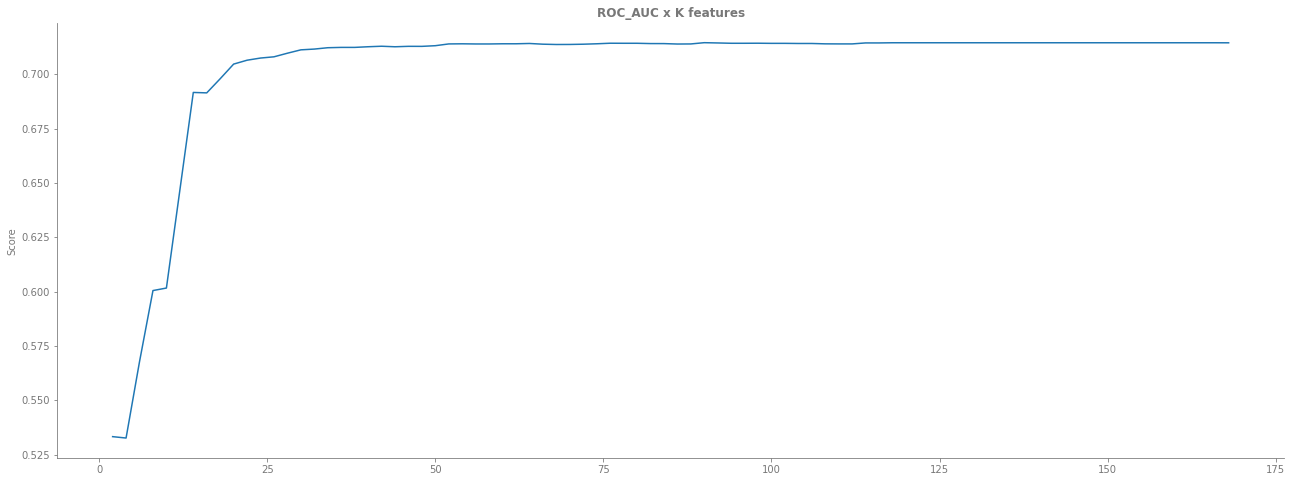

In [ ]:
#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

#Aplicando os parâmetros no matplotlib/seaborn
with plt.rc_context(rc_params):

  #instanciando o axes e figure do matplotlib
  fig, ax = plt.subplots(figsize = (22,8))

  #Construindo o gráfico 
  sns.lineplot(
                x = df_feature_selection.index.to_list(),
                y = df_feature_selection['Score'],
                ci = None,
                ax = ax,
              )
  
  #Colocando o título no gráfico
  ax.set_title("ROC_AUC x K features")

  #Exibindo o gráfico
  plt.show()

Podemos notar que mesmo variando o conjunto de features, o modelo obteve uma ROC_AUC próxima a alcançada na fase de otimização dos hyperparâmetros. Diante disto, vamos escolher uma região viável que tenha uma ROC_AUC estável e que reduza a quantidade de features do modelo para diminuir a complexidade.

Portanto, iremos utilizar as colunas escolhidas pelo algoritmo para a iteração do K = 90.

O próximo passo é verificar quais são estas colunas.

In [ ]:
#Instanciando o SelectFromModel
selector = SelectFromModel(model_rl, 
                           max_features = 90, 
                           threshold = -np.inf)
  
#Treinando o SelectFromModel
selector.fit(X_train_rus, y_train_rus)

#Armazena as features escolhidas
mask = X_train_rus.columns[selector.get_support()].to_list()

#Imprimindo as colunas
mask

['score_3',
 'score_4',
 'score_5',
 'score_6',
 'risk_rate',
 'income',
 'facebook_profile',
 'n_accounts',
 'n_issues',
 'application_time_applied',
 'application_time_in_funnel',
 'external_data_provider_credit_checks_last_month',
 'external_data_provider_credit_checks_last_year',
 'external_data_provider_email_seen_before',
 'external_data_provider_fraud_score',
 'reported_income',
 'a15',
 'aty',
 'b19',
 'c55',
 'da',
 'dfa',
 'n1',
 'n14',
 'n16',
 'n2',
 'n3',
 'n4',
 'n6',
 'nim',
 'proaty',
 'mais_freq',
 'score_1_1Rk8w4Ucd5yR3KcqZzLdow==',
 'score_1_4DLlLW62jReXaqbPaHp1vQ==',
 'score_1_8k8UDR4Yx0qasAjkGrUZLw==',
 'score_1_DGCQep2AE5QRkNCshIAlFQ==',
 'score_1_e4NYDor1NOw6XKGE60AWFw==',
 'score_1_fyrlulOiZ+5hoFqLa6UbDQ==',
 'score_1_smzX0nxh5QlePvtVf6EAeg==',
 'score_2_+CxEO4w7jv3QPI/BQbyqAA==',
 'score_2_7h8PTkrlTWUPP3yuyP4rUg==',
 'score_2_A+QuW1n/ABeiVVe/9CRZ9Q==',
 'score_2_Fv28Bz0YRTVAT5kl1bAV6g==',
 'score_2_IOVu8au3ISbo6+zmfnYwMg==',
 'score_2_LCak332j+TYFqHC3NDwiqg==',

#### Otimização de Ponto de Corte

Nesta etapa buscaremos otimizar o valor de **Ponto de Corte**, ou seja, o valor limite que separa as predições em classes. As predições são dadas em forma de probabilidade e o valor limite é 0.5 como padrão. 

Como a métrica principal é a ROC_AUC e não leva em consideração o ponto de corte, devemos escolher outra métrica para buscarmos a sua otimização. Portanto, escolheremos a **f1_score** que é definida a partir de uma média harmônica entra recall e precision.

O objetivo desta etapa é encontrar o ponto de corte ótimo que maximize a métrica escolhida através de uma validação cruzada.

In [ ]:
#Selecionando as features escolhidas e criando um novo X_train
X_train_rus_selector = X_train_rus[mask]

#Criando uma lista para armazenar os valores
score_medio = []
lista_cutoff = []

#Criando um loop
for cont in range(1, 98, 1):

  #Variando o ponto de corte
  cutoff = 0.01 + cont * 0.01

  #Criando uma variável para armazenar o score dos splits do K_fold
  score_cutoff = []

  #Loop nos index do k_fold
  for train_index, test_index in k_fold.split(X_train_rus_selector):

    #Seprando o treino e teste com base no index do K_fold
    X_train, X_test = X_train_rus_selector.loc[train_index], X_train_rus_selector.loc[test_index]
    y_train, y_test = y_train_rus.loc[train_index], y_train_rus.loc[test_index]

    #Instanciando o StandardScaler()
    scaler = StandardScaler()
    
    #Padronizando as variáveis numéricas
    for feature in list(s1.intersection(s2)):

      X_train[feature] = scaler.fit_transform(X_train[feature].values.reshape(-1,1))
      X_test[feature] = scaler.transform(X_test[feature].values.reshape(-1,1))
    
    #Fitando o modelo de regressão logística
    model_rl.fit(X = X_train, y = y_train)

    #Calculando a probabilidade de y nos dados de teste
    y_proba = model_rl.predict_proba(X_test)

    #Armazenando a probabilidade
    y_proba_df = pd.DataFrame(y_proba)

    #Definindo o valor de y de acordo com o ponto de corte
    y_proba_df['Predict'] = y_proba_df[1].apply(lambda x: 1 if x > cutoff else 0)

    #Calculando a métrica F1_Score com o ponto de corte utilizado
    score_cutoff.append(f1_score(y_test, y_proba_df['Predict']))

  #Armazenando os valores
  lista_cutoff.append(cutoff)
  score_medio.append(np.mean(score_cutoff))

In [ ]:
#Criando um Dataframe
cutoff_df = pd.DataFrame(score_medio, index = lista_cutoff, columns = ['Cutoff'])

#Imprimindo o valor máx da métrica de F1_Score
cutoff_df.loc[cutoff_df['Cutoff'] == cutoff_df['Cutoff'].max()]

,Cutoff
0.35,0.698252


Como podemos observar o valor 0.35 de ponto de corte é o que maximiza o F1_Score. 

#### Avaliando o Modelo Escolhido na Base de Teste

O próximo passo é avaliarmos a performance do modelo escolhido em relação aos dados de teste.

              precision    recall  f1-score   support

           0       0.73      0.16      0.27       827
           1       0.54      0.94      0.68       850

    accuracy                           0.56      1677
   macro avg       0.63      0.55      0.48      1677
weighted avg       0.63      0.56      0.48      1677

AUC Score:  0.6810157194679564
--------------------------------------------------------------------


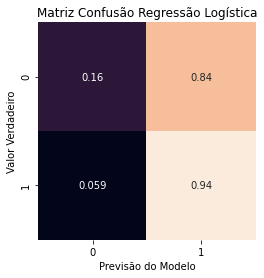

In [ ]:
#Copiando o dataframe do X_train e X_test
X_train_rus_scaled = X_train_rus_selector.copy()
X_test_scaled = X_test[mask].copy()

#Padronizando as variáveis numéricas
for feature in list(s1.intersection(s2)):

  #Ajustando as variáveis numéricas do X_train
  X_train_rus_scaled[feature] = scaler.fit_transform(X_train_rus_scaled[feature].values.reshape(-1,1))

  #Ajustando as variáveis numéricas de X_test com os mesmos parâmetros do X_train
  X_test_scaled[feature] = scaler.transform(X_test_scaled[feature].values.reshape(-1,1))

#Treinando o modelo
model_rl.fit(X = X_train_rus_scaled, y = y_train_rus)

#Calculando a probabilidade y
y_proba = model_rl.predict_proba(X_test_scaled)

#Transformando em um dataframe
y_proba_df = pd.DataFrame(y_proba)

#Calculando a predição utilizando o cutoff de 0.51
y_proba_df['Predict'] = y_proba_df[1].apply(lambda x: 1 if x > 0.35 else 0)

# Classification Report
print(classification_report(y_test, y_proba_df['Predict']))

print("AUC Score: ",roc_auc_score(y_test, y_proba[:,1]))

print("--------------------------------------------------------------------")

#Instanciando a figure e axes
fig, ax = plt.subplots()

#Plotando a matriz de confusão em um heatmap
sns.heatmap(confusion_matrix(y_test, y_proba_df['Predict'], normalize = 'true'), 
            square=True, 
            annot=True, 
            cbar=False,
            ax = ax)

#Definindo o nome do eixo x
ax.set_xlabel("Previsão do Modelo")

#Definindo o nome do eixo y
ax.set_ylabel("Valor Verdadeiro")

#Definindo o título
ax.set_title("Matriz Confusão Regressão Logística")

#Exibindo a matriz de confusão
plt.show()

## Conclusão

O modelo de machine learning escolhido se baseou na métrica **ROC_AUC** com o intuito do modelo ter uma capacidade de separabilidade entre as classes.

Diante disto, o modelo que melhor se adequou foi a Regressão Logística, alcançando uma **ROC_AUC** na validação cruzada com todas otimizações de 71%. Vale destacar também que seu resultado no dataset de teste (68%) foi próximo ao de validação.

Além disso, foi utilizado uma otimização de ponto de corte com base na métrica **f1_Score**, conseguindo maximizar o resultado para o valor de 70%, próximo ao obtido na fase de teste. 

É importante ressaltar que este projeto tem margem para melhoria em feature engineering, na aplicação de outros métodos de features selection e modelo de machine learning.

Com estas informações, é possível a empresa prever dentre aos novos dados de consumidores quais podem ser inadimplentes, podendo a empresa direcionar ações que busquem minimizar estas perdas.